In [251]:
import glob

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from matplotlib.dates import DateFormatter

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg') # set it here to 'png' or 'svg'

import seaborn as sns
#sns.set()
# Use white grid plot background from seaborn
sns.set(style="whitegrid")



In [295]:

actions = pd.concat((pd.read_csv(f) for f in glob.glob("logs-2021-*/actions.csv")))



people = pd.concat((pd.read_csv(f) for f in glob.glob("logs-2021-*/people.csv")))

children = pd.concat((pd.read_csv(f) for f in glob.glob("logs-2021-*/nb_children.csv")))

moods = pd.concat((pd.read_csv(f) for f in glob.glob("logs-2021-*/moods.csv")))

# process timestamp, and index dataframes by time
for df in [actions, people, children, moods]:
    del df["level"]
    df["time"] = pd.to_datetime(df.time, unit="s")
    df["day"] = df.time.dt.floor('D')
    df["timeofday"] = pd.Timestamp(0) + (df.time - df.day)
    
    #del df["time"]
    
    df.set_index("timeofday", inplace=True)
    
    

# dataframe containing only the people who have been 'recognised' by the robot
users = people.loc[(people["user_id"] != -1) & (people["user_id"] != 0)]

In [296]:
people

,time,person_id,user_id,x,y,z,x_world,y_world,z_world,looking_at_robot,engaged,age,day
timeofday,,,,,,,,,,,,,
1970-01-01 08:44:52.787008000,2021-06-15 08:44:52.787008000,5933,-1,0.600819,0.476078,1.288513,-1.485479,0.546711,1.288513,0.000000,seen,child,2021-06-15
1970-01-01 08:44:53.737517056,2021-06-15 08:44:53.737517056,5933,-1,0.555188,0.481914,1.345984,-1.457658,0.510075,1.345984,0.000000,seen,child,2021-06-15
1970-01-01 08:44:54.743941120,2021-06-15 08:44:54.743941120,5933,-1,0.555188,0.481914,1.345984,-1.457318,0.603369,1.575342,0.777778,engaging,child,2021-06-15
1970-01-01 08:44:55.681817088,2021-06-15 08:44:55.681817088,5933,0,0.555188,0.481914,1.345984,-1.457318,0.603369,1.575342,0.777778,engaging,child,2021-06-15
1970-01-01 08:44:56.613306880,2021-06-15 08:44:56.613306880,5933,0,0.000000,0.000000,0.000000,-1.457318,0.603369,1.575342,0.000000,disappearing,child,2021-06-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 13:51:08.478714112,2021-06-16 13:51:08.478714112,59762,2761,0.000000,0.000000,0.000000,-0.390132,0.075556,1.423666,0.000000,disengaging,adult,2021-06-16
1970-01-01 13:51:09.490355968,2021-06-16 13:51:09.490355968,59762,2761,0.000000,0.000000,0.000000,-0.390132,0.075556,1.423666,0.000000,disappearing,adult,2021-06-16
1970-01-01 13:51:10.479386112,2021-06-16 13:51:10.479386112,59762,2761,0.000000,0.000000,0.000000,-0.390132,0.075556,1.423666,0.000000,disappearing,adult,2021-06-16


Percentage of people who were 'recognised' by the robot (ie, assigned a `user_id`):

In [277]:
len(users)/len(people) * 100

36.64531402311656

# How long people interacted with the robot?

TypeError: Passing integers to fillna for timedelta64[ns] dtype is no longer supported.  To obtain the old behavior, pass `pd.Timedelta(seconds=n)` instead.

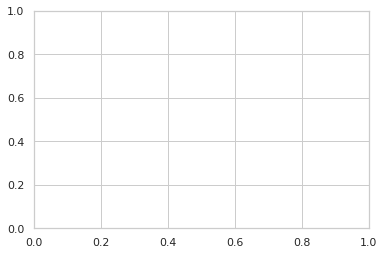

In [278]:
interaction_time = (people.groupby(["person_id"])["time"].max() - people.groupby(["person_id"])["time"].min())
(interaction_time/60).sort_values().plot.bar(title="How long people have been seen?", ylabel="minutes",xticks=[],xlabel="person")


Descriptive stats on duration of tracking:

In [279]:
interaction_time.describe()

count                          549
mean     0 days 00:05:46.526991284
std      0 days 01:28:19.888816310
min                0 days 00:00:00
25%      0 days 00:00:10.148606976
50%      0 days 00:00:17.839638016
75%      0 days 00:00:33.484903936
max      1 days 01:06:46.144260864
Name: time, dtype: object

# Where were the people?

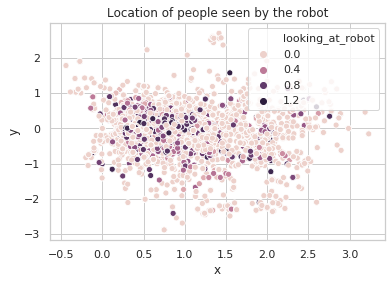

In [280]:
_ = sns.scatterplot(people.x, people.y, hue=people.looking_at_robot).set_title("Location of people seen by the robot")

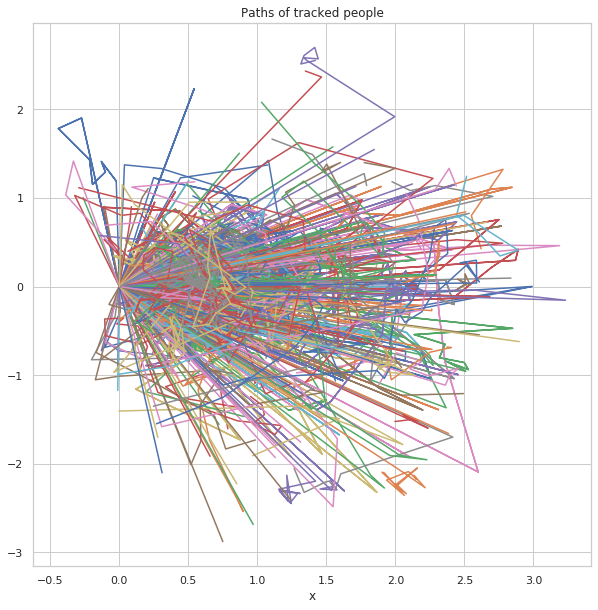

In [281]:
fig, ax = plt.subplots(figsize=(10,10))
_ = people.groupby("person_id").plot.line("x", "y", ax=ax,legend=False,title="Paths of tracked people")

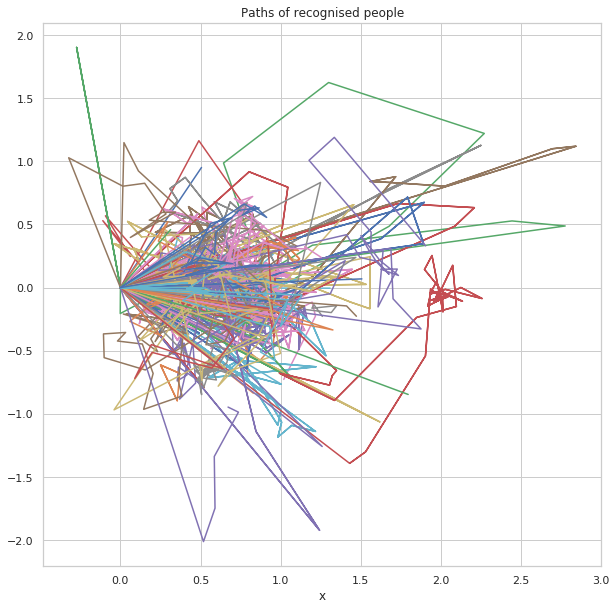

In [282]:
fig, ax = plt.subplots(figsize=(10,10))
_ = users.groupby("user_id").plot.line("x", "y", ax=ax,legend=False, title="Paths of recognised people")

# How many children interacted with the robot?

In [297]:
children

,time,nb_children,day
timeofday,,,
1970-01-01 08:37:07.606162944,2021-06-15 08:37:07.606162944,1,2021-06-15
1970-01-01 08:37:11.284563968,2021-06-15 08:37:11.284563968,0,2021-06-15
1970-01-01 08:37:25.642936832,2021-06-15 08:37:25.642936832,1,2021-06-15
1970-01-01 08:37:34.114775040,2021-06-15 08:37:34.114775040,0,2021-06-15
1970-01-01 08:44:44.870235904,2021-06-15 08:44:44.870235904,1,2021-06-15
...,...,...,...
1970-01-01 13:51:08.979813120,2021-06-16 13:51:08.979813120,0,2021-06-16
1970-01-01 13:53:25.579304960,2021-06-16 13:53:25.579304960,1,2021-06-16
1970-01-01 13:53:35.265434880,2021-06-16 13:53:35.265434880,0,2021-06-16


### Raw data: number of children engaged with the robot over time

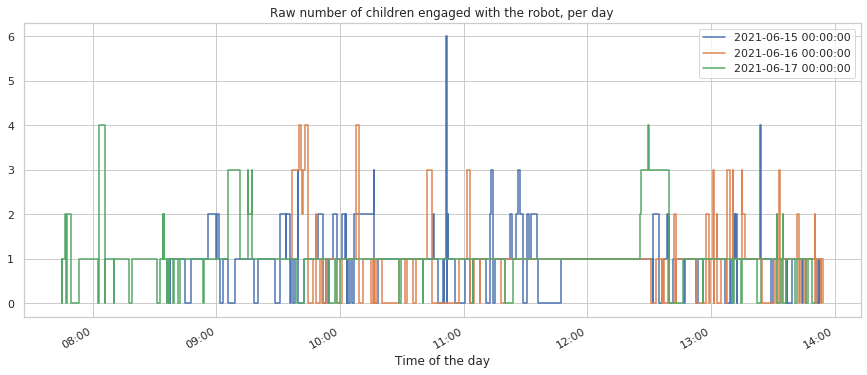

In [298]:
fig, ax = plt.subplots(figsize=(15, 6))
# Define the date format
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)

children.groupby("day").nb_children.plot(drawstyle='steps-pre', legend=True)

ax.set(xlabel="Time of the day",
       title="Raw number of children engaged with the robot, per day")
pass

### Cumulative sum of children interacting with the robot

In [299]:
children["shifted"] = children.shift(1, fill_value=0).nb_children
children["increase"] = (children.nb_children - children.shifted).clip(0)
children["cumsum"] = children.groupby("day").increase.cumsum()

children["cumsum"]

<ipython-input-299-d58b642ff94e>:1: FutureWarning: Passing <class 'int'> to shift is deprecated and will raise in a future version, pass Timestamp instead.
  children["shifted"] = children.shift(1, fill_value=0).nb_children


timeofday
1970-01-01 08:37:07.606162944     1
1970-01-01 08:37:11.284563968     1
1970-01-01 08:37:25.642936832     2
1970-01-01 08:37:34.114775040     2
1970-01-01 08:44:44.870235904     3
                                 ..
1970-01-01 13:51:08.979813120    62
1970-01-01 13:53:25.579304960    63
1970-01-01 13:53:35.265434880    63
1970-01-01 13:54:11.600630016    64
1970-01-01 13:54:11.601829120    64
Name: cumsum, Length: 334, dtype: int64

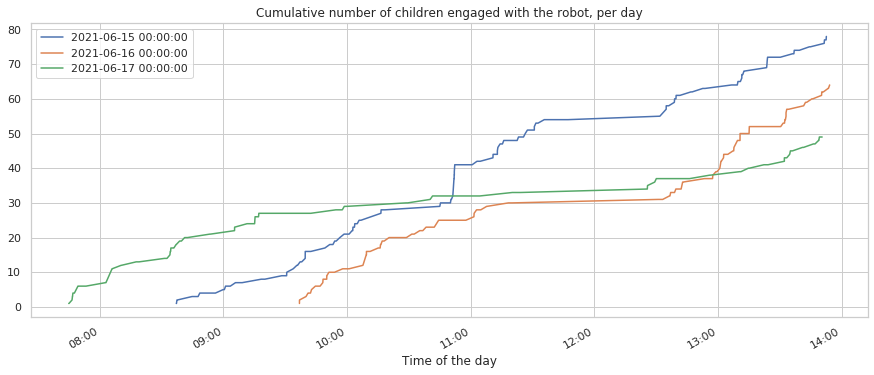

In [300]:
fig, ax = plt.subplots(figsize=(15, 6))
# Define the date format
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)

children.groupby("day")["cumsum"].plot(legend=True)

ax.set(xlabel="Time of the day",
       title="Cumulative number of children engaged with the robot, per day")
pass

### Computation of # of children interacting with the robot in a given time window

In a given time window, the number of interacting children is equal to the number of children interacting with the robot when the window starts + the sum of children joining the interaction over the window. For instance:
  - t0: 2 children present
  - t1: 1 child present
  - t3: 2 children present -> 1 child joined
  - t4: 4 children present -> 2 more children joined
  
  => 2 + 1 + 2 = 5 children who interacted with the robot during that time window
  
This computation is performed independently for each day.
 

In [331]:
WINDOW="5min"

windows=pd.date_range(pd.Timestamp(0) + pd.Timedelta("07:30:00"), pd.Timestamp(0) + pd.Timedelta("15:15:00"), freq=WINDOW)
d = {'timeofday':[], 'interacting_children':[]}

def interacting_children_per_day(children):
    
    for i in range(len(windows)-1):

        # if no logs at that time, record 0 child and continue
        if windows[i] < children.index[0] or windows[i] > children.index[-1]:
            d['timeofday'].append(windows[i])
            d['interacting_children'].append(0)
            continue

        if i > 1:
            try:
                initial_nb_children = children[windows[i-1]:windows[i]].iloc[-1].nb_children
            except IndexError:
                initial_nb_children = 0    
        else:
            initial_nb_children = 0

        sum_increase = children[windows[i]:windows[i+1]].increase.sum()

        total_interacting_children = initial_nb_children + sum_increase
        
        d['timeofday'].append(windows[i])
        d['interacting_children'].append(total_interacting_children)

    df = pd.DataFrame(data=d)
    df = df.set_index('timeofday')
    return df

interacting_children = children.groupby("day").apply(interacting_children_per_day)
interacting_children.reset_index(inplace=True)

interacting_children


,day,timeofday,interacting_children
0,2021-06-15,1970-01-01 07:30:00,0
1,2021-06-15,1970-01-01 07:35:00,0
2,2021-06-15,1970-01-01 07:40:00,0
3,2021-06-15,1970-01-01 07:45:00,0
4,2021-06-15,1970-01-01 07:50:00,0
...,...,...,...
553,2021-06-17,1970-01-01 14:50:00,0
554,2021-06-17,1970-01-01 14:55:00,0
555,2021-06-17,1970-01-01 15:00:00,0
556,2021-06-17,1970-01-01 15:05:00,0


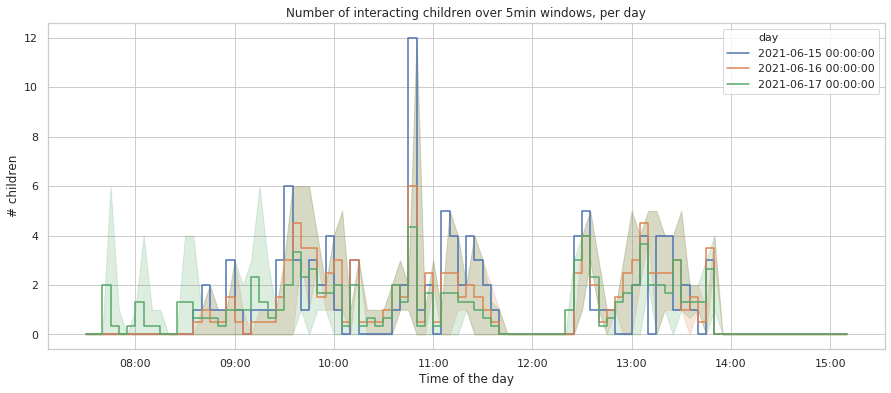

In [346]:
fig, ax = plt.subplots(figsize=(15, 6))
# Define the date format
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)

sns.lineplot(data=interacting_children,y="interacting_children",x="timeofday",hue="day", drawstyle="steps-pre")

ax.set(xlabel="Time of the day",
       ylabel="# children",
       title="Number of interacting children over %s windows, per day" % WINDOW)
pass

KeyError: 'Requested level (timeofday) does not match index name (None)'

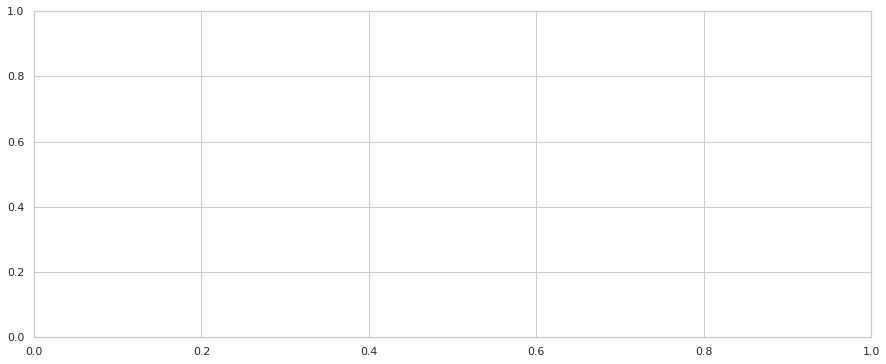

In [347]:
fig, ax = plt.subplots(figsize=(15, 6))

interacting_children.reset_index("timeofday").set_index("day").groupby("timeofday").mean().plot(ax=ax,drawstyle="steps-pre",legend=False)

# Define the date format
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)

ax.set(xlabel="Time of the day",
       title="Number of interacting children per windows of %s, average over full study" % WINDOW)

for xc in windows[::3]:
    ax.axvline(x=xc, color='silver', linestyle='--',zorder=0)

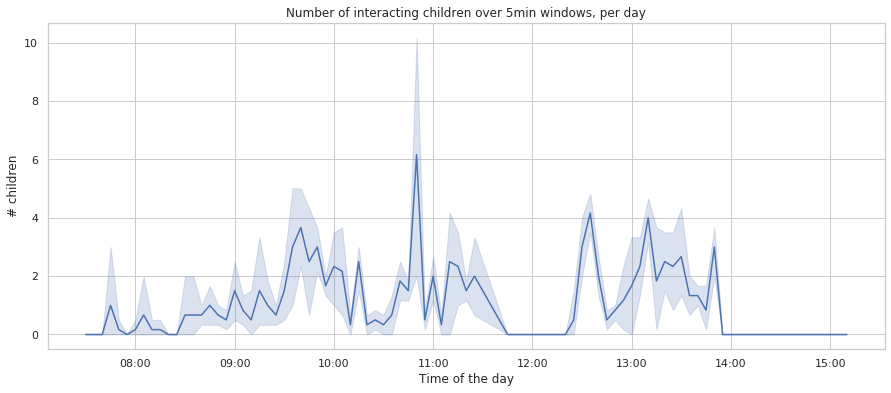

In [349]:
fig, ax = plt.subplots(figsize=(15, 6))
# Define the date format
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)

sns.lineplot(data=interacting_children,y="interacting_children",x="timeofday")

ax.set(xlabel="Time of the day",
       ylabel="# children",
       title="Number of interacting children over %s windows, per day" % WINDOW)
pass

# Activities

In [308]:
activities = actions[(actions.status == "running") & (actions.activity != "default") & (actions.activity != "mood board")]
activities

,time,activity,status,day
timeofday,,,,
1970-01-01 08:45:02.301182976,2021-06-15 08:45:02.301182976,fun dances,running,2021-06-15
1970-01-01 08:45:52.962519040,2021-06-15 08:45:52.962519040,relaxing sounds,running,2021-06-15
1970-01-01 08:56:37.893854976,2021-06-15 08:56:37.893854976,fun dances,running,2021-06-15
1970-01-01 08:57:15.485510144,2021-06-15 08:57:15.485510144,jokes,running,2021-06-15
1970-01-01 08:58:37.556745984,2021-06-15 08:58:37.556745984,jokes,running,2021-06-15
...,...,...,...,...
1970-01-01 13:28:08.578398976,2021-06-16 13:28:08.578398976,relaxing sounds,running,2021-06-16
1970-01-01 13:28:57.548566016,2021-06-16 13:28:57.548566016,fun dances,running,2021-06-16
1970-01-01 13:34:05.805506048,2021-06-16 13:34:05.805506048,fun dances,running,2021-06-16


In [309]:
activities_count = activities.groupby(["day","activity"])["status"].count().reset_index()
activities_count

,day,activity,status
0,2021-06-15,calm dances,6
1,2021-06-15,calm music,6
2,2021-06-15,cuddle,8
3,2021-06-15,fun dances,11
4,2021-06-15,jokes,14
5,2021-06-15,listening,9
6,2021-06-15,relaxing sounds,5
7,2021-06-15,story,4
8,2021-06-16,calm music,7
9,2021-06-16,cuddle,8


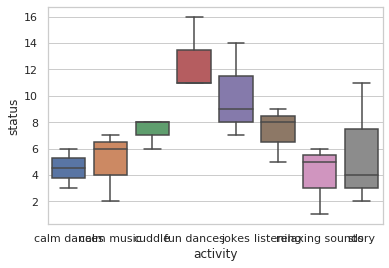

In [310]:
g = sns.boxplot(data=activities_count,x="activity",y="status")

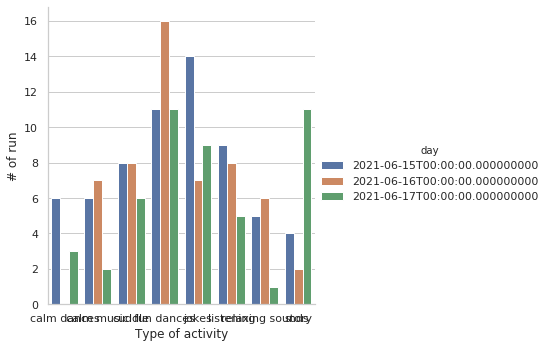

In [311]:
g = sns.catplot(data=activities_count,hue='day',x="activity",y="status",kind="bar")
g.set_axis_labels("Type of activity", "# of run")